/Users/danila.pankov/Documents/emp2/convoys/convoys/regression.py:198: UserWarning: Warning! Removed 10/849 entries from inputs where T <= 0 or B not 0/1 or W < 0
  'T <= 0 or B not 0/1 or W < 0' % (n_removed, len(X)))
loss:     -2244.33711 |#                            | 1 [Elapsed Time: 0:00:00]/Users/danila.pankov/opt/anaconda3/envs/convoys_3613/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/danila.pankov/Documents/emp2/convoys/convoys/regression.py:49: RuntimeWarning: invalid value encountered in multiply
  W * B * LL_observed +
loss:     -904.710981 |#                           | 37 [Elapsed Time: 0:00:00]

As of 01/05/21 17:14, the best batch is BATCH-3.
Conversion rate is 0.366
It is better than the second best batch with probability 0.94
Number of observations in batches for 01/05/21 17:14: 
BATCH-8    104
BATCH-6    100
BATCH-4    100
BATCH-5     98
BATCH-1     98
BATCH-7     97
BATCH-3     97
BATCH-2     96
BATCH-0     59
Name: batch_number, dtype: int64


100% |###########################################| 120 walkers [ETA:  00:00:00]

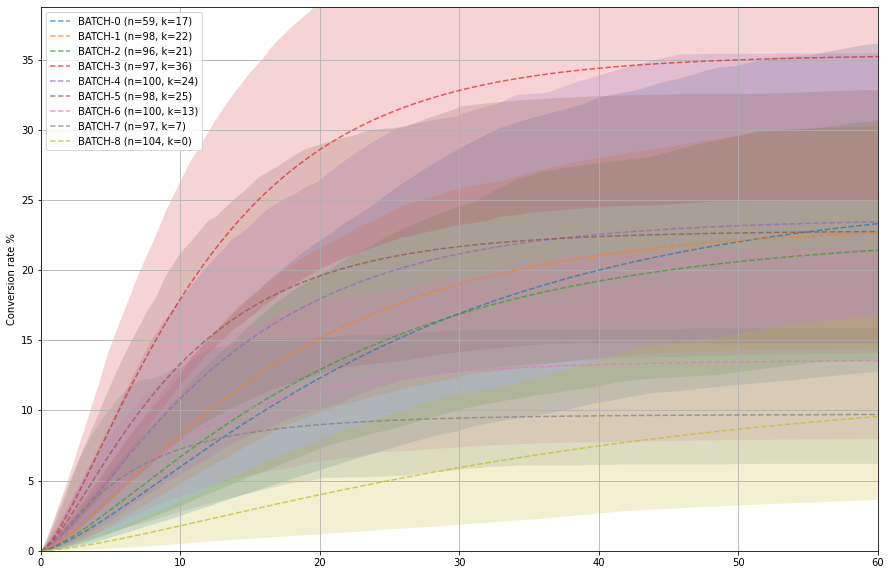

As of 01/05/21 17:14, the best batch is BATCH-3.
Conversion rate is 0.366
It is better than the second best batch with probability 0.93


In [108]:
import pandas as pd
import convoys as convoys
import convoys.utils
import convoys.plotting
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

#select the input file
file_path='input.csv'

#choose the time for whichi you want to see evaluation
current_date='01/04/21 17:14'




def load_data(input_file_path):
    #this function simply reads the data
    return pd.read_csv(input_file_path)

def clean_data(df0, date):
    #this function cleans the loaded data:
    #inputs - loaded dataframe
    #outputs - dataframe with correct entries in the fields in the right format
    
    
    #drops missing values for the first_contact date if it is null 
    
    df1=df0.dropna(subset=['first_contact_date']).copy()
    
    df2=df1.copy()
    df2['batch_number']=df1['batch_number'].astype('category')
    df2['link_sent_date']=pd.to_datetime(df1.link_sent_date, format='%d/%m/%y %H:%M').dt.date
    df2['first_contact_date']=pd.to_datetime(df1.first_contact_date, format='%d/%m/%y %H:%M').dt.date
    df2['conversion_date']=pd.to_datetime(df1.agreement_reached_date, format='%d/%m/%y %H:%M').dt.date
    df2['now']=date
    df2['now']=pd.to_datetime(df2['now'], format='%d/%m/%y %H:%M').dt.date
    df3=df2[((df2['first_contact_date']<=df2['link_sent_date']) | (df2['link_sent_date'].isnull()))  &
          ((df2['link_sent_date']<=df2['conversion_date']) | (df2['conversion_date'].isnull()))
        ].copy()
    #keeps observations where first_contract_date is lower than link_sent_date 
    #keeps observations where link_sent_date is lower than agreement_reached_date
    df4=df3[(df3['first_contact_date']+pd.Timedelta(days=0)<df3['now'])].copy()
    return df4

def show_nonparamteric_graphs(df):
    #this function plots the nonparametric graph of conversions
    #inputs - cleaned dataframe
    #outputs - graph
    unit, groups, (G, B, T) = convoys.utils.get_arrays(
    df, groups='batch_number', created='first_contact_date', converted='conversion_date',
    unit='days', group_min_size=50)
    convoys.plotting.plot_cohorts(G, B, T, model='kaplan-meier', ci=0.95, groups=groups, t_max=60)
    plt.legend()
    plt.show()

def show_gamma_dist(df):
    #this function parametrizes conversion and plots the parametric graph
    #inputs - cleaned dataframe
    #outputs - graph and conversion parameter estimates
    unit, groups, (G, B, T) = convoys.utils.get_arrays(
    df, groups='batch_number', created='first_contact_date', converted='conversion_date',
    unit='days', group_min_size=50)
    plt.figure(figsize=(15,10))
    [m, conv_dict]=convoys.plotting.plot_cohorts(G, B, T, model='gamma', groups=groups, ci=0.95, t_max=60, plot_kwargs={'linestyle': '--'})
    #plt(figsize=(8, 6), dpi=80)
    plt.legend()
    #plt.rcParams["figure.figsize"] = (20,3)
    plt.show()
    return conv_dict

def numerical_results(conv_dict):
    #this function allows to see a "winner" among the batches 
    #and tests statistically how good is the winner
    #inputs - conversion estimates for each batched from a parametrized model
    #outputs - prints the description of conversion estimation
    df0=pd.DataFrame(conv_dict).transpose().reset_index().rename(columns={'index':'batch_number', 0: 'interval_min', 1: 'interval_max'})
    #print(df0)
    df=df0[df0['interval_min']>0].copy()
    
    #corner case = no conversion estimates different from zero statistically
    if len(df.index)==0: 
        print("No batch with conversion rate different from 0 statistically")
        
    #corner case = one conversion estimate different from zero statistically
    elif len(df.index)==1:
        print("As of {0}, the best batch is {1}"
              .format(current_date,df['batch_number'].iloc[0]))
        
        conv=round((df['interval_min'].iloc[0]+df['interval_max'].iloc[0])/2, 3)
        print("It equals {0} and is stat. significantly different from 0"
                .format(conv) )
    #normal case = two and more conversion estimate different from zero statistically
    else: 
        df['conv']=(df['interval_min']+df['interval_max'])/2
        df['rank']=df[['conv']].rank(method='dense', ascending= False)
         
        conv_diff=(df[ df['rank']==1]['conv'].values[0]-df[ df['rank']==2]['conv'].values[0])
        
        sd1=(df.loc[ df['rank']==1,'conv']-df.loc[ df['rank']==1,'interval_min']).values[0]/2
        sd2=(df.loc[ df['rank']==2,'conv']-df.loc[ df['rank']==2,'interval_min']).values[0]/2
        conv_diff_sd=math.sqrt(sd1*sd1+sd2*sd2)
        t=conv_diff/conv_diff_sd
        
        print("As of {0}, the best batch is {1}."
              .format(current_date,df[df['rank']==1]['batch_number'].iloc[0]))
        print("Conversion rate is {0}".format(round(df[ df['rank']==1]['conv'].values[0],3)))
        print("It is better than the second best batch with probability {0}"
             .format(round(norm.cdf(t),2)))
df=numerical_results(conv_dict)



def present_results(date, input_file_path):
    #this function takes as inputs:
    #the date for which you would like reporting
    #shows the graphical results
    df0=load_data(input_file_path)
    df1=clean_data(df0, date)
    print("Number of observations in batches for {0}: ".format(date))
    print(df1.batch_number.value_counts())
    
    #show_nonparamteric_graphs(df1)
    conv_dict=show_gamma_dist(df1)
    numerical_results(conv_dict)
    return conv_dict

conv_dict=present_results(current_date, file_path)